<a href="https://colab.research.google.com/github/ved-mohan/CS8803DRL_Paper/blob/main/CSC_Code_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will walk through a toy implementation of the CSC, or the Conservative Safety Critic, algorithm by Bharadhwaj et al. (2021). The algorithm provides an online actor-critic approach by which to learn an environment in a "safe" manner, or avoid veering into states with low reward that correspond to dangerous states, while balancing this with actual performance.

In [ ]:
!pip install shimmy gymnasium==0.29.0 gym==0.26.2 stable-baselines3 torch
!pip uninstall -y box2d-py
!pip install Box2D

In [ ]:
# imports
import os
import gymnasium as gym
from stable_baselines3 import PPO
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


Training CSC...
Episode 50/5000, Reward: -245.73, Avg Reward: -374.41, Cat Failures: 3943
Episode 100/5000, Reward: -97.33, Avg Reward: -158.51, Cat Failures: 6952
Episode 150/5000, Reward: -125.00, Avg Reward: -117.88, Cat Failures: 9867
Episode 200/5000, Reward: -128.77, Avg Reward: -136.11, Cat Failures: 13247
Episode 250/5000, Reward: -91.43, Avg Reward: -211.35, Cat Failures: 16645
Episode 300/5000, Reward: -197.90, Avg Reward: -156.05, Cat Failures: 20176
Episode 350/5000, Reward: -578.55, Avg Reward: -189.98, Cat Failures: 23543
Episode 400/5000, Reward: -157.16, Avg Reward: -265.42, Cat Failures: 27254
Episode 450/5000, Reward: -472.69, Avg Reward: -288.92, Cat Failures: 31207
Episode 500/5000, Reward: -25.61, Avg Reward: -193.16, Cat Failures: 34894
Episode 550/5000, Reward: -75.55, Avg Reward: -108.23, Cat Failures: 37980
Episode 600/5000, Reward: -153.97, Avg Reward: -126.67, Cat Failures: 41366
Episode 650/5000, Reward: -132.42, Avg Reward: -127.83, Cat Failures: 44780
Epi

<ipython-input-24-e0cde24221cb>:292: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load(policy_path, map_location=device))


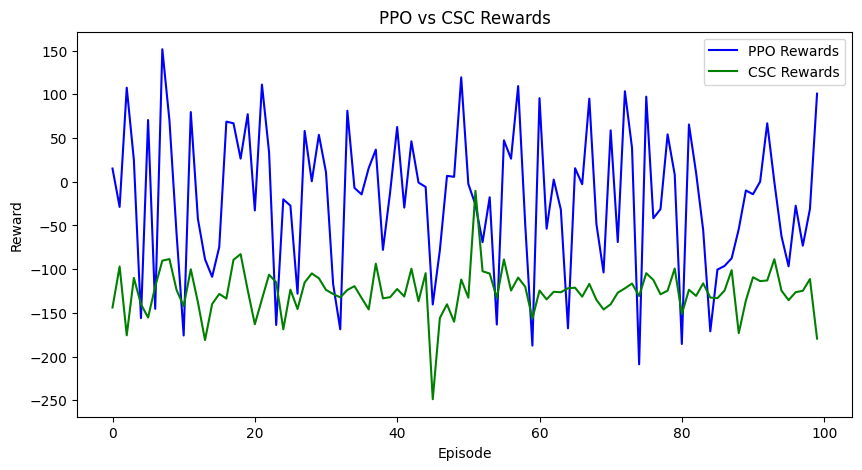

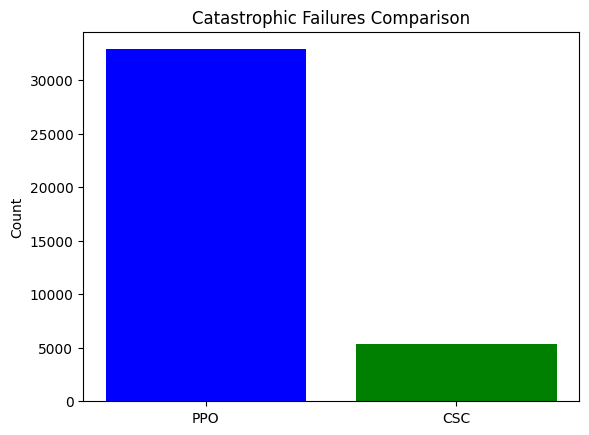

Catastrophic Failures (PPO): 32876
Catastrophic Failures (CSC): 5314


In [ ]:
# File paths
PPO_MODEL_PATH = "ppo_model.zip"
CSC_POLICY_PATH = "csc_policy.pt"
CSC_CRITIC_PATH = "csc_critic.pt"
CSC_VALUE_PATH = "csc_value.pt"

def make_env(env_name="LunarLander-v2"):
    return gym.make(env_name)

#########################################
# Networks
#########################################

class SafetyCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128, num_layers=4, dropout_prob=0.2):
        super(SafetyCritic, self).__init__()

        self.action_dim = action_dim

        layers = [
            nn.Linear(state_dim + action_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(dropout_prob)
        ]

        for _ in range(1, num_layers):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.LayerNorm(hidden_dim))
            layers.append(nn.LeakyReLU(negative_slope=0.01))
            layers.append(nn.Dropout(dropout_prob))

        layers.append(nn.Linear(hidden_dim, 1))
        layers.append(nn.Sigmoid())

        self.model = nn.Sequential(*layers)
        self.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, state, action):
        action_one_hot = torch.zeros(action.shape[0], self.action_dim, device=action.device)
        action_one_hot[torch.arange(action.shape[0]), action.squeeze(-1)] = 1
        x = torch.cat([state, action_one_hot], dim=-1)
        return self.model(x)

class CSCPolicy(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128, num_layers=4, dropout_prob=0.2):
        super(CSCPolicy, self).__init__()

        layers = [
            nn.Linear(state_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(dropout_prob),
        ]

        for _ in range(1, num_layers):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.LayerNorm(hidden_dim))
            layers.append(nn.LeakyReLU(negative_slope=0.01))
            layers.append(nn.Dropout(dropout_prob))

        layers.append(nn.Linear(hidden_dim, action_dim))
        layers.append(nn.Softmax(dim=-1))

        self.model = nn.Sequential(*layers)
        self.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, state):
        return self.model(state)

# Value function network for baseline
class ValueNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim=128, num_layers=4, dropout_prob=0.2):
        super(ValueNetwork, self).__init__()

        layers = [
            nn.Linear(state_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(dropout_prob)
        ]

        for _ in range(1, num_layers):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.LayerNorm(hidden_dim))
            layers.append(nn.LeakyReLU(negative_slope=0.01))
            layers.append(nn.Dropout(dropout_prob))

        layers.append(nn.Linear(hidden_dim, 1))
        layers.append(nn.Sigmoid())

        self.model = nn.Sequential(*layers)
        self.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, state):
        return self.model(state)

#########################################
# Utility Functions
#########################################

def compute_returns(rewards, gamma=0.99):
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.append(G)
    returns.reverse()
    return returns

#########################################
# CSC Training Function
#########################################

def train_csc(env,
              num_episodes=5000,
              gamma=0.99,
              penalty_coef=0.1,   # Reduced penalty
              entropy_coef=0.01,  # Entropy bonus
              save_models=True):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    policy = CSCPolicy(state_dim, action_dim).to(device)
    safety_critic = SafetyCritic(state_dim, action_dim).to(device)
    value_net = ValueNetwork(state_dim).to(device)

    policy_optimizer = optim.Adam(policy.parameters(), lr=1e-3)
    safety_optimizer = optim.Adam(safety_critic.parameters(), lr=1e-3)
    value_optimizer = optim.Adam(value_net.parameters(), lr=1e-3)
    loss_fn = nn.BCELoss()
    value_loss_fn = nn.MSELoss()

    all_rewards = []
    catastrophic_failures = 0

    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        states, actions, rewards, cat_labels = [], [], [], []

        while not done:
            s_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                action_probs = policy(s_tensor)
            action_dist = torch.distributions.Categorical(action_probs)
            action = action_dist.sample()

            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated

            states.append(state)
            actions.append(action.item())
            rewards.append(reward)
            cat_labels.append(1.0 if reward < 0 else 0.0)

            if reward < 0:
                catastrophic_failures += 1

            state = next_state

        # Compute returns for this episode
        returns = compute_returns(rewards, gamma)

        states_tensor = torch.FloatTensor(states).to(device)
        actions_tensor = torch.LongTensor(actions).to(device)
        cat_labels_tensor = torch.FloatTensor(cat_labels).unsqueeze(1).to(device)
        returns_tensor = torch.FloatTensor(returns).unsqueeze(1).to(device)

        # Train the safety critic
        pred_cat_probs = safety_critic(states_tensor, actions_tensor)
        safety_loss = loss_fn(pred_cat_probs, cat_labels_tensor)
        safety_optimizer.zero_grad()
        safety_loss.backward()
        safety_optimizer.step()

        # Get predicted catastrophe probs
        with torch.no_grad():
            cat_probs = safety_critic(states_tensor, actions_tensor)

        # Train the value network to predict returns
        value_preds = value_net(states_tensor)
        value_loss = value_loss_fn(value_preds, returns_tensor)
        value_optimizer.zero_grad()
        value_loss.backward()
        value_optimizer.step()

        # Compute advantages: A = R - V
        with torch.no_grad():
            values = value_net(states_tensor)
        advantages = returns_tensor - values

        # Incorporate catastrophe penalty into the advantage
        adjusted_advantages = advantages - penalty_coef * cat_probs

        # Policy update
        action_probs_all = policy(states_tensor)
        chosen_action_probs = torch.gather(action_probs_all, 1, actions_tensor.unsqueeze(1))
        log_probs = torch.log(chosen_action_probs + 1e-8)

        # Entropy term for exploration
        entropy = -(action_probs_all * torch.log(action_probs_all + 1e-8)).sum(dim=1).mean()

        policy_loss = -(log_probs * adjusted_advantages.detach()).mean() - entropy_coef * entropy

        policy_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer.step()

        episode_reward = sum(rewards)
        all_rewards.append(episode_reward)
        if (episode + 1) % 50 == 0:
            print(f"Episode {episode+1}/{num_episodes}, Reward: {episode_reward:.2f}, "
                  f"Avg Reward: {np.mean(all_rewards[-50:]):.2f}, "
                  f"Cat Failures: {catastrophic_failures}")

    if save_models:
        torch.save(policy.state_dict(), CSC_POLICY_PATH)
        torch.save(safety_critic.state_dict(), CSC_CRITIC_PATH)
        torch.save(value_net.state_dict(), CSC_VALUE_PATH)
        print("CSC models saved.")

    return all_rewards, catastrophic_failures

#########################################
# PPO Training for Comparison
#########################################

def train_ppo(env, num_timesteps=50000, save_model=True):
    model = PPO("MlpPolicy", env, verbose=1)
    model.learn(total_timesteps=num_timesteps)
    if save_model:
        model.save(PPO_MODEL_PATH)
        print("PPO model saved.")
    return model

#########################################
# Evaluation and Plotting
#########################################

def evaluate_ppo(env, model, num_episodes=100):
    rewards = []
    catastrophic_failures = 0
    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        episodic_reward = 0
        while not done:
            action, _ = model.predict(state)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episodic_reward += reward
            if reward < 0:
                catastrophic_failures += 1
        rewards.append(episodic_reward)
    return rewards, catastrophic_failures

def evaluate_csc(env, policy_path, value_path, num_episodes=100, device="cpu"):
    # Load trained CSC policy and value network
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    policy = CSCPolicy(state_dim, action_dim)
    policy.load_state_dict(torch.load(policy_path, map_location=device))
    policy.to(device)
    policy.eval()

    rewards = []
    catastrophic_failures = 0
    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        episodic_reward = 0
        while not done:
            s_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                action_probs = policy(s_tensor)
            action_dist = torch.distributions.Categorical(action_probs)
            action = action_dist.sample().item()

            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episodic_reward += reward
            if reward < 0:
                catastrophic_failures += 1
        rewards.append(episodic_reward)
    return rewards, catastrophic_failures

def plot_results(ppo_rewards, csc_rewards, ppo_failures, csc_failures):
    plt.figure(figsize=(10, 5))
    plt.plot(ppo_rewards, label="PPO Rewards", color="blue")
    plt.plot(csc_rewards, label="CSC Rewards", color="green")
    plt.title("PPO vs CSC Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.show()

    plt.bar(["PPO", "CSC"], [ppo_failures, csc_failures], color=["blue", "green"])
    plt.title("Catastrophic Failures Comparison")
    plt.ylabel("Count")
    plt.show()

#########################################
# Main Flow
#########################################

if __name__ == "__main__":
    env_name = "LunarLander-v2"
    env = make_env(env_name)

    print("\nTraining PPO...")
    ppo_model = train_ppo(env)
    ppo_rewards, ppo_failures = evaluate_ppo(env, ppo_model)

    print("\nTraining CSC...")
    csc_rewards, csc_failures = train_csc(env)

    # Evaluate CSC after training
    csc_eval_rewards, csc_eval_failures = evaluate_csc(env, CSC_POLICY_PATH, CSC_VALUE_PATH)

    plot_results(ppo_rewards, csc_eval_rewards, ppo_failures, csc_eval_failures)
    print(f"Catastrophic Failures (PPO): {ppo_failures}")
    print(f"Catastrophic Failures (CSC): {csc_eval_failures}")


### Figure 2: Catastrophic failures comparison

Empirical results demonstrate CSC achieves lower average catastrophic failure rates during training compared to methods like PPO. This makes it particularly suitable for environments where safety during the learning process is critical.

### Figure 1: Why CSC May Lag Behind PPO:

1. **Safety Constraints:**
   - CSC imposes safety constraints using the conservative safety critic. This ensures that exploration avoids unsafe regions, limiting the policy's ability to explore freely and discover high-reward actions quickly.
   - PPO, on the other hand, does not inherently account for safety and focuses entirely on maximizing task rewards, which can lead to faster reward improvement in unconstrained environments.

2. **Conservative Updates:**
   - CSC uses a KL-divergence constraint to ensure policy updates are conservative. While this prevents drastic policy changes and maintains safety, it can slow the learning process compared to PPO's more flexible update scheme.
